In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=50, max_depth=10)
#или параметры могут быть заданы
rfr = RandomForestRegressor(random_state=1111)
rfr.n_estimators = 50
rfr.max_depth = 10

for i, item in enumerate(rfr.feature_importances_): #получение важности признака
    print("{0:s}: {1:.2f}".format(X.columns[i], item))

In [ ]:
#задача классификации, данные крестики-нолики
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=1111)
rfc.fit(X_train, y_train)
rfc.predict(X_test)
pd.Series(rfc.predict(X_test)).value_counts()
rfc.predict_proba(X_test) #получение вероятности

rfc = RandomForestClassifier(random_state=1111)
rfc.get_params() #получение параметров модели и их значений
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test) #точность классификации

Разделение на train - validation - test

In [ ]:
#разделение на train - validation - test (60-20-20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                  test_size=0.2, random_state=1111)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                  test_size=0.25, random_state=11111)

In [ ]:
#MAE
from sklearn.metrics import mean_absolute_error,  mean_squared_error
mean_absolute_error(y_test, test_predictions)
mean_squared_error(y_test, test_predictions)

#оценка точности на подкатегориях
chocolate_preds = rfr.predict(X_test[X_test[:, 1] == 1]) #для nonchocolate_preds 0
mean_absolute_error(y_test[X_test[:, 1] == 1], chocolate_preds)

In [ ]:
#построение матрицы
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_predictions)
print(cm) # array([[ 23, 7], [ 8, 62]])
cm[1, 0] # 8

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy_score(y_test, test_predictions)
precision_score(y_test, test_predictions)
recall_score(y_test, test_predictions)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
cross_val_score(estimator=rfc, X=X, y=y, cv=5) #по умолчанию использует
# функцию оценки по умолчанию для любой указанной модели

#если хотим использовать определенную оценку
from sklearn.metrics import mean_absolute_error, make_scorer
mae_scorer = make_scorer(mean_absolute_error)
cross_val_score(<estimator>, <X>, <y>, cv=5, scoring=mae_scorer)

In [ ]:
#LOOCV
mse = make_scorer(mean_squared_error)
cv_results = cross_val_score(estimator, X, y, scoring=mse, cv= X.shape[0])
print(cv_results.mean())

Настройка гиперпараметров

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)
print(lr.coef_, lr.intercept_)

rfc = RandomForestRegressor(...)
rfc.get_params() # гиперпараметры

In [ ]:
#RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV()
param_dist = {"max_depth": [4, 6, 8, None], "max_features": range(2, 11), "min_samples_split": range(2, 11)}

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
rfr = RandomForestRegressor(n_estimators=20, random_state=1111)
scorer = make_scorer(mean_absolute_error)

random_search = RandomizedSearchCV(estimator=rfr, param_distributions=param_dist, n_iter=40, cv=5)
random_search.fit(X, y)

#rs - реализация RandomizedSearchCV()
rs.best_score_
rs.best_params_ #{'max_depth': 4, 'max_features': 8, 'min_samples_split': 4}
rs.best_estimator_

rs.cv_results_ # словарь
rs.cv_results_['mean_test_score'] #для каждого запуска средняя оценка теста CV
rs.cv_results_['params'] #для каждого запуска все выбранные параметры

max_depth = [item['max_depth'] for item in rs.cv_results_['params']]
scores = list(rs.cv_results_['mean_test_score'])
d = pd.DataFrame([max_depth, scores]).T
d.columns = ['Max Depth', 'Score']
d.groupby(['Max Depth']).mean()

rs.best_estimator_ #содержит модель, которая показала наилучшие результаты во время перекрестной проверки
rs.best_estimator_.predict(<new_data>) #предсказать новые данные
random_search.best_estimator_.get_params() #проверить все параметры

from sklearn.externals import joblib
joblib.dump(rfr, 'rfr_best_<date>.pkl') # сохранить модель в формате pickle

Таблица оценки название признаков

In [ ]:
log_reg_clf = LogisticRegression() # красиво переменная и оценка
log_reg_clf.fit(X_train, y_train)
print(log_reg_clf.coef_)
# array([[-2.886, -8.231, 7.50,..., -4.393, cont... ]])

original_variables = list(X_train.columns)
zipped_together = list(zip(original_variables, log_reg_clf.coef_[0]))
coefs = [list(x) for x in zipped_together]
coefs = pd.DataFrame(coefs, columns=["Variable", "Coefficient"])

coefs.sort_values(by=["Coefficient"], axis=0, inplace=True, ascending=False)
print(coefs.head(3)) # переменная коэффциент

Извлечение решений узла

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
X, y = datasets.load_iris(return_X_y=True, as_frame = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, train_size=0.2,
                                                    random_state=42, shuffle=True, stratify=y)

In [10]:
#параметры дерева - переменная и значение разеделения (параметры в узлах)
rf_clf = RandomForestClassifier(max_depth=2)
rf_clf.fit(X_train, y_train)
chosen_tree = rf_clf.estimators_[7] # выбрали дерево из ансамбля
# дерево, которое мы вытащили, является «древовидным» объектом
split_column = chosen_tree.tree_.feature[1]
split_column_name = X_train.columns[split_column]
# сопоставляя его с нашими X_train столбцами, чтобы получить имя
split_value = chosen_tree.tree_.threshold[1] # уровень разделения
print("This node split on feature {}, at a value of {}".format(split_column_name, split_value))
# "This node split on feature PAY_0, at a value of 1.5"

This node split on feature petal width (cm), at a value of 0.75


Объект GridSearchCV аргументы:
*   estimator - наш алгоритм
*   param_grid
*   cv - можно указать различные типы перекрестной проверки но и число
*   scoring
*   refit - true, означает, что для подгонки к обучающим данным используются наилучшие комбинации гиперпараметров. Объект GridSearchCV можно использовать непосредственно в качестве оценщика Это очень удобно, так как вам не нужно сохранять наши лучшие гиперпараметры и обучать другую модель.
*   n_jobs - помогает при параллельном выполнении
*   return_train_score - полезно для построения графика и понимания производительности теста и обучающего набора



In [ ]:
sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=None,
                                     refit=True, cv='warn', verbose=0, pre_dispatch='2*n_jobs',
                                     error_score='raise-deprecating', return_train_score='warn')

In [7]:
import os
print(os.cpu_count()) # проверить, сколько ядер

from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [1, 2, 4, 6]}
rf_class = RandomForestClassifier(criterion='entropy', max_features='auto')
grid_rf_class = GridSearchCV(estimator = rf_class, param_grid = param_grid,
                scoring='accuracy',n_jobs=4, cv = 10, refit=True, return_train_score=True)
grid_rf_class.fit(X_train, y_train)
grid_rf_class.predict(X_test) # если для refit = True то можно использовать лучшую

2


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


array([0, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 1, 1, 2, 0, 0, 0, 1, 1, 2, 1, 0,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 0, 2, 0,
       2, 2, 0, 0, 2, 1, 2, 0, 0, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 0, 0, 2,
       1, 2, 2, 1, 1, 1, 2, 0, 0, 0, 2, 1, 2, 1, 2, 2, 0, 1, 1, 0, 2, 1,
       2, 2, 0, 1, 0, 0, 1, 1, 2, 0])

Свойства объекта (GridSearchCV) можно разделить на три различные группы:
* A results log

    cv_results_
* The best results

    best_index_ , best_params_& best_score_
* 'Extra information'

    scorer_ , n_splits_ & refit_time_


In [16]:
import pandas as pd
cv_results_df = pd.DataFrame(grid_rf_class.cv_results_)
print(cv_results_df.shape) # (12, 23) 12 кавадратов
#есть столбцы время, столбцы param и есть prams словарь всех параметров
cv_results_df.T.head()

(16, 32)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
mean_fit_time,0.511103,0.526153,0.715394,0.957369,0.858333,0.502308,0.518504,0.516663,0.498831,0.509396,0.508556,0.524297,0.91202,0.942994,0.60076,0.460606
std_fit_time,0.045916,0.061828,0.200116,0.099006,0.088445,0.030333,0.02901,0.038435,0.067707,0.054816,0.046438,0.058007,0.125714,0.079947,0.101935,0.091521
mean_score_time,0.026875,0.026816,0.034425,0.039197,0.029384,0.024206,0.02232,0.023896,0.023839,0.021446,0.025087,0.025315,0.044317,0.039782,0.024236,0.023238
std_score_time,0.004045,0.008727,0.00641,0.010809,0.011695,0.003602,0.003505,0.006429,0.004247,0.008502,0.00831,0.006282,0.006981,0.010769,0.005609,0.010841
param_max_depth,2,2,2,2,4,4,4,4,6,6,6,6,8,8,8,8


In [17]:
pd.set_option("display.max_colwidth", -1) # печать всего
print(cv_results_df.loc[:,"params"])
# столбцы: test и train score для каждого сгиба и среднее и стандартное отклонение
# последний столбец - ранжирование по mean_test_score

0     {'max_depth': 2, 'min_samples_leaf': 1}
1     {'max_depth': 2, 'min_samples_leaf': 2}
2     {'max_depth': 2, 'min_samples_leaf': 4}
3     {'max_depth': 2, 'min_samples_leaf': 6}
4     {'max_depth': 4, 'min_samples_leaf': 1}
5     {'max_depth': 4, 'min_samples_leaf': 2}
6     {'max_depth': 4, 'min_samples_leaf': 4}
7     {'max_depth': 4, 'min_samples_leaf': 6}
8     {'max_depth': 6, 'min_samples_leaf': 1}
9     {'max_depth': 6, 'min_samples_leaf': 2}
10    {'max_depth': 6, 'min_samples_leaf': 4}
11    {'max_depth': 6, 'min_samples_leaf': 6}
12    {'max_depth': 8, 'min_samples_leaf': 1}
13    {'max_depth': 8, 'min_samples_leaf': 2}
14    {'max_depth': 8, 'min_samples_leaf': 4}
15    {'max_depth': 8, 'min_samples_leaf': 6}
Name: params, dtype: object


<ipython-input-17-286ec9caf1b3>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1) # печать всего


In [21]:
best_row = cv_results_df[cv_results_df["rank_test_score"] == 1]
print(best_row)
#установили return_train_score значение True, это не включало бы оценки обучения



*   best_params_ - словарь параметров
*   best_score_ - лучший результат
*   best_index_ - строка по лучшему mean_test_score



In [23]:
print(grid_rf_class.best_estimator_) # благодаря refit=True при создании поиска
#sklearn.ensemble.forest.RandomForestClassifier

RandomForestClassifier(criterion='entropy', max_depth=2, max_features='auto')


* scorer_ - функция оценки

* n_splits_ -количество разделов перекрестной проверки

* refit_time_ - количество секунд, затраченных на переоборудование лучшей модели для всего набора данных




Random Search

Различия в n_iter и param_distributiobs - при необходимости вы можете предоставить информацию о том, как выполнить выборку, например, с использованием определенного предоставленного вами дистрибутива

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
learn_rate_list = np.linspace(0.001,2,150)
min_samples_leaf_list = list(range(1,51))
parameter_grid = {'learning_rate' : learn_rate_list, 'min_samples_leaf' : min_samples_leaf_list}
number_models = 10

random_GBM_class = RandomizedSearchCV(estimator = GradientBoostingClassifier(), param_distributions = parameter_grid,
                                      n_iter = number_models, scoring='accuracy', n_jobs=4, cv = 10,
                                      refit=True, return_train_score = True)
random_GBM_class.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=4,
                   param_distributions={'learning_rate': array([1.00000000e-03, 1.44161074e-02, 2.78322148e-02, 4.12483221e-02,
       5.46644295e-02, 6.80805369e-02, 8.14966443e-02, 9.49127517e-02,
       1.08328859e-01, 1.21744966e-01, 1.35161074e-01, 1.48577181e-01,
       1.61993289e-01, 1.75409396e-01, 1.88825503e-01, 2.022416...
       1.82559060e+00, 1.83900671e+00, 1.85242282e+00, 1.86583893e+00,
       1.87925503e+00, 1.89267114e+00, 1.90608725e+00, 1.91950336e+00,
       1.93291946e+00, 1.94633557e+00, 1.95975168e+00, 1.97316779e+00,
       1.98658389e+00, 2.00000000e+00]),
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...]},
                   return_train_score=True, scoring='accuracy')

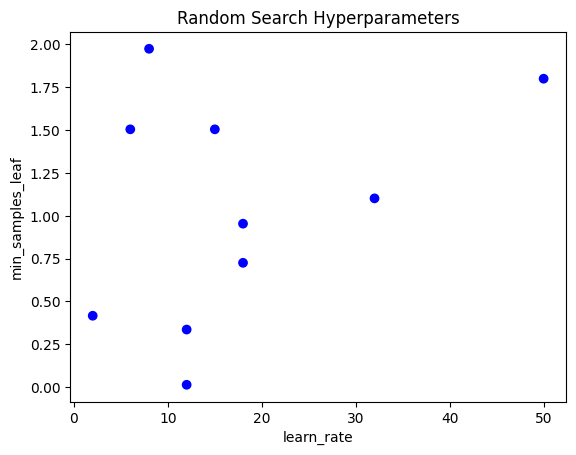

In [26]:
rand_x = list(random_GBM_class.cv_results_['param_learning_rate'])
rand_y = list(random_GBM_class.cv_results_['param_min_samples_leaf'])

x_lims = [np.min(learn_rate_list), np.max(learn_rate_list)]
y_lims = [np.min(min_samples_leaf_list), np.max(min_samples_leaf_list)]

import matplotlib.pyplot as plt
plt.scatter(rand_y, rand_x, c=['blue']*10)
plt.gca().set(xlabel='learn_rate', ylabel='min_samples_leaf', title='Random Search Hyperparameters')
plt.show()

То что было неинформированный поиск. Информированный это случайный поиск + определяем границы и добиваем локально. К примеру, байесовский подход.

Байесовская настройка гиперпараметров

Правило Байеса на самом деле является методом, с помощью которого мы можем итеративно использовать новые доказательства, чтобы обновить наши убеждения о результате

Пакет для байесовской настройки гиперпараметров - Hyperopt

* установить домен (сетку)
* установить алгоритм оптимизации
* целевая функция для минимизации



In [ ]:
space = {'max_depth': hp.quniform('max_depth', 2, 10, 2),
          'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 8, 2),
          'learning_rate': hp.uniform('learning_rate', 0.01, 1, 55)}
# домен = сетка где каждая точка вероятность гиперпараметра
# quniform означает однородный, но квантованный (или биннированный) указанным третьим числом

In [ ]:
# целевую функцию для запуска алгоритма (конспект)
def objective(params):
    params = {'max_depth': int(params['max_depth']), 'min_samples_leaf': int(params['min_sampes_leaf']),
    'learning_rate': params['learning_rate']}
    gbm_clf = GradientBoostingClassifier(n_estimators=500, **params)
    best_score = cross_val_score(gbm_clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=4).mean()
    loss = 1 - best_score
    write_results(best_score, params, iteration)
    return loss
# нужно вызвать алгоритм
best_result = fmin(fn=objective, space=space, max_evals=500, rstate=np.random.default_rng(42),
                    algo=tpe.suggest)

Информированный поиска с использованием настройки генетических гиперпараметров

In [ ]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=3, population_size=5, verbosity=2,
                      offspring_size=10, scoring='accuracy', cv=5)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))